# Exercise 01:  Minimal high-level UQ example

This notebook demonstrates high-level ("non-expert") UQ with CUQIpy on a 1D Deconvolution test problem and optional 2D problems.

Help, guidance, installation instruction etc. can be found in the [CUQIpy documentation](https://cuqi-dtu.github.io/CUQIpy/).

## Learning objectives of this notebook:
- Get acquainted with the CUQIpy components needed to specify a Bayesian inverse problem.
- Run a high-level UQ analysis of an inverse problem.

## Table of contents: 
* [1. UQ in just a few lines of code!](#UQ5)
* [2. Loading a test problem](#TestProblem)
* [3. Specifying and solving a Bayesian inverse problem ](#Bayesian)
* [4. ★ Changing the prior](#ChangingPrior)
* [5. ★ Gibbs sampling for hierarchical problems](#Gibbs)

*The last two sections marked by "★" are optional - try running through sections 1, 2, 3 before attempting the exercises, and before sections 4 and 5.*

First we import any python packages we need, here simply NumPy to handle array computations and matplotlib for plotting:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Then we import the functionality we need from CUQIpy:

In [2]:
from cuqi.distribution import Gaussian, Gamma, LMRF, CMRF, GMRF
from cuqi.problem import BayesianProblem
from cuqi.testproblem import Deconvolution1D, Deconvolution2D

In [3]:
# Print version for reproducibility
import cuqi
print(cuqi.__version__)

0.5.0


## 1. UQ in a few lines of code!   <a class="anchor" id="UQ5"></a> 

In just a few lines of CUQIpy code we can:
- load a forward model and data from a 1D deconvolution test problem,
- specify distributions for prior and data,
- formulate a Bayesian inverse problem with observed data, and
- run a UQ analysis.

The 1D deconvolution test problem is a linear inverse problem with additive noise:

$$ \mathbf{y} = \mathbf{A}\mathbf{x}+\mathbf{e},$$
where 
- $\mathbf{A}\in\mathbb{R}^{n\times n}$, is a blurring operator, 
- $\mathbf{x}\in\mathbb{R}^n$ is an unknown 1D signal of length $n$ to be determined,
- $\mathbf{y}\in\mathbb{R}^n$ is an observed blurred and noisy signal, and
- $\mathbf{e}\in\mathbb{R}^n$ is additive noise.

We load in the forward model `A` and observed data `y_data` from the test problem:

In [4]:
A, y_data, probInfo = Deconvolution1D.get_components(phantom="sinc")

We assume (as a prior) that the elements of $\mathbf{x}$ follow a so-called Gaussian Markov Random Field [(GMRF)](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.GMRF.html#cuqi.distribution.GMRF), which assumes a Gaussian distribution on the differences of the unknown. For the additive noise we assume i.i.d. Gaussian with zero mean and variance $\sigma_e^2$, i.e., precision $d_e = 1/\sigma_e^2$,
$$
\begin{align}
\mathbf{x}&\sim\mathrm{GMRF}(\mathbf{0},50), \\
\mathbf{e}&\sim\mathcal{N}(\mathbf{0},d_e^{-1}\mathbf{I}_n)
\end{align}
$$

From the distribution of $\mathbf{e}$ and the linear model we can write up this with the distribution of $\mathbf{y}$ instead:
$$
\begin{align}
\mathbf{x}&\sim\mathrm{GMRF}(\mathbf{0},50), \\
\mathbf{y}&\sim\mathcal{N}(\mathbf{Ax},d_e^{-1}\mathbf{I}_n).
\end{align}$$

which in CUQIpy can be written as follows for known noise precision:

In [5]:
d_e_true = 1/0.01**2 # Actual noise precision from test problem

x = GMRF(np.zeros(A.domain_dim), 50)
y = Gaussian(A@x, cov=1/d_e_true)

Notice the close correspondence between the mathematical formulation and the CUQIpy code.

We can carry out a UQ analysis given observed data $\mathbf{y}=\mathbf{y}^\mathrm{data}$ by:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Linear_RTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 5.208997964859009
Plotting results


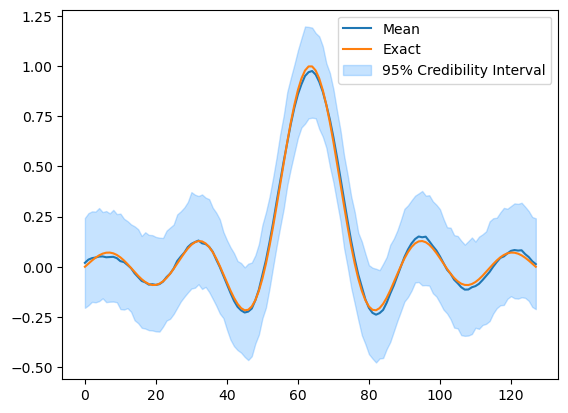

In [6]:
BP = BayesianProblem(y,x).set_data(y=y_data)
BP.UQ(exact=probInfo.exactSolution)

If the noise precision is not known, we can include it as a parameter to be estimated in the inverse problem. We extend the Bayesian problem by assuming the precision follows a Gamma distribution in a hierarchical problem:
$$
\begin{align*}
d_e   &\sim \mathrm{Gamma}(1, 10^{-4}), \\
\mathbf{x} &\sim \mathrm{GMRF}(\mathbf{0},50), \\
\mathbf{y} &\sim \mathcal{N}(\mathbf{Ax},d_e^{-1}\mathbf{I}_n).
\end{align*}
$$

In [7]:
d_e = Gamma(1, 1e-4)
x = GMRF(np.zeros(A.domain_dim), 50)
y = Gaussian(A@x, cov=lambda d_e : 1/d_e)

UQ analysis given observed data $\mathbf{y}=\mathbf{y}^\mathrm{data}$, now on the extended problem using a Gibbs sampler:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: Linear_RTO
	d_e: Conjugate

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 10.53900694847107
Plotting results


{'x': <cuqi.samples._samples.Samples at 0x14d193b25f0>,
 'd_e': <cuqi.samples._samples.Samples at 0x14d193d2290>}

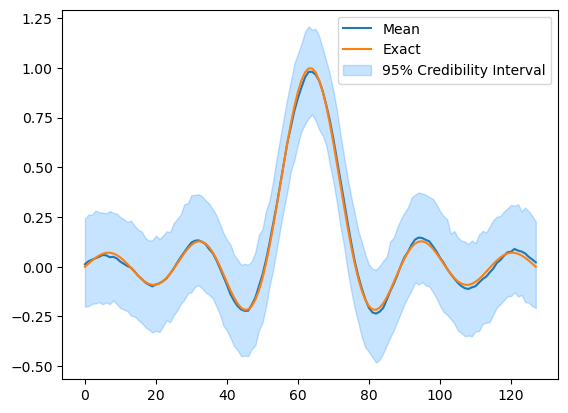

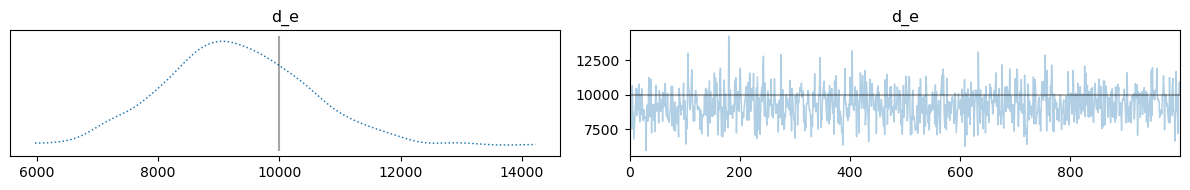

In [8]:
BP = BayesianProblem(y, x, d_e).set_data(y=y_data)
BP.UQ(exact={"x":probInfo.exactSolution, "d_e":d_e_true})

The plots for the hyperparameter $d_e$ are called trace plots. They show the density estimate (left) and chain (right).

In the following sections of this notebook we break it down and take a slightly closer look at each step. The subsequent notebooks provide additional details.

## 2. Loading a test problem  <a class="anchor" id="TestProblem"></a> 

The 1D deconvolution test problem is a linear inverse problem with additive noise:

$$ \mathbf{y} = \mathbf{A}\mathbf{x}+\mathbf{e},$$
where 
- $\mathbf{A}\in\mathbb{R}^{n\times n}$, is a blurring operator, 
- $\mathbf{x}\in\mathbb{R}^n$ is an unknown 1D signal of length $n$ to be determined,
- $\mathbf{y}\in\mathbb{R}^n$ is an observed blurred and noisy signal, and
- $\mathbf{e}\in\mathbb{R}^n$ is additive noise.

We load in the forward model `A` and observed data `y_data` from the test problem:

In [9]:
A, y_data, probInfo = Deconvolution1D.get_components(phantom="sinc")

Here we use the variable name `A` to match the mathematics. But `A` is a CUQIpy model, not a matrix.

Note that the test problem can be configured (e.g. other phantoms, noise types and level etc.) by means of the inputs, see `help(Deconvolution1D)` for details.

Several other test problems are available (click links to see online docs):
- [Deconvolution1D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution1D.html#cuqi.testproblem.Deconvolution1D): 1D periodic deconvolution problem.
- [Deconvolution2D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Deconvolution2D.html#cuqi.testproblem.Deconvolution2D): 2D deconvolution (deblurring) problem.
- [Heat1D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Heat1D.html):  Heat equation PDE problem.
- [Poisson1D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Poisson1D.html): Poisson equation PDE problem.
- [Abel1D](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.testproblem/cuqi.testproblem.Abel1D.html):  Abel equation PDE (1D rotationally symmetric CT) problem. 

These are imported as follows:

In [10]:
from cuqi.testproblem import Deconvolution2D, Heat1D, Poisson1D, Abel1D

and their calling signature is the same as for the `Deconvolution1D` problem, e.g. 
```
model, data, probInfo = Heat1D.get_components()
```
Input arguments vary and default values are provided if left empty. Instead of checking the onlinen docs, calling help of each testproblem, e.g., `help(Heat1D)` will also describe the test problem and the inputs it accepts

For now, proceeding with the `Deconvolution1D` test problem, we take a look at the model and see that it is a CUQIpy LinearModel:

In [11]:
A

CUQI LinearModel: Continuous1D(128,) -> Continuous1D(128,).
    Forward parameters: ['x'].

We take a look at the data:

In [12]:
y_data

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 _DefaultGeometry1D(128,)

Parameters:
 True

Array:
CUQIarray([ 3.09381962e-02,  2.24069305e-02,  4.03003822e-02,
            3.30739848e-02,  2.97740142e-02,  1.84574482e-02,
            1.18848155e-02,  2.98579639e-02,  9.45130428e-03,
            6.09271892e-03,  5.30874578e-03,  1.09253577e-02,
            1.71569499e-03,  4.01120393e-04,  1.10422035e-02,
            2.45974158e-02, -1.50060309e-03,  5.11636486e-03,
            7.63893045e-03, -5.74838313e-03,  1.01276041e-02,
           -6.82682139e-03,  5.71711928e-03,  2.02235278e-02,
           -5.51002725e-03,  6.03308335e-05, -5.04269865e-03,
            2.11840926e-02,  3.50164414e-03,  2.27176132e-03,
            4.58799203e-04,  3.70286826e-05,  3.94716082e-03,
            2.10967213e-02,  1.53693272e-02,  1.35729941e-02,
            2.10480610e-02,  6.75810646e-03,  1.57949687e-02,
            1.59350583e-02,  3.0668852

The data is a `CUQIarray`, which is a normal NumPy array further equipped with a few utilities, such as Geometry, which allows us to do plotting conveniently:

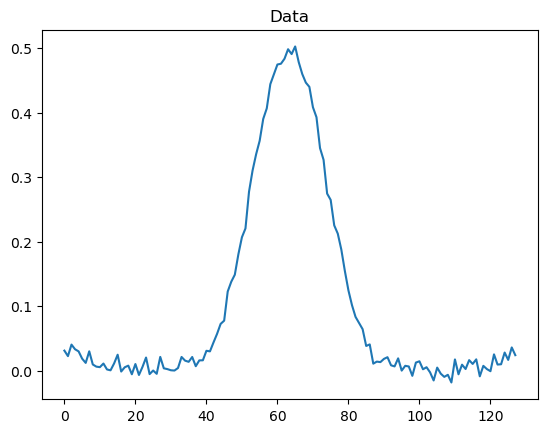

In [13]:
y_data.plot()
plt.title("Data");

The last thing returned by the test problem was `probInfo` which contains additional information about the test problem, typically it includes the exact solution (phantom) and the exact data. We take a look at both:

In [14]:
probInfo

ProblemInfo with the following set attributes:
['exactData', 'exactSolution', 'infoString']
 infoString: Noise type: Additive Gaussian with std: 0.01

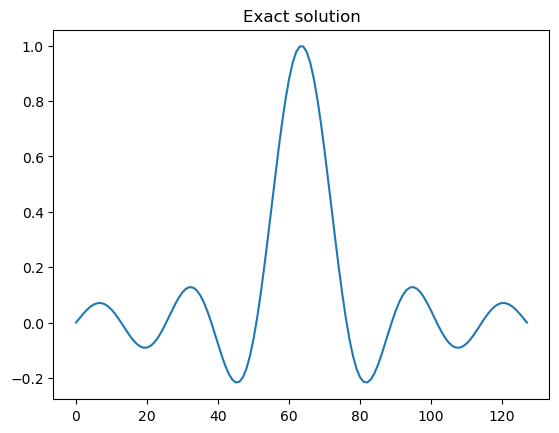

In [15]:
probInfo.exactSolution.plot()
plt.title("Exact solution");

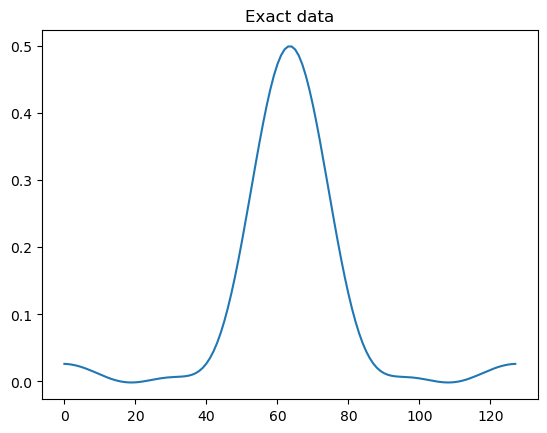

In [16]:
probInfo.exactData.plot()
plt.title("Exact data");

Since `CUQIarray` is a NumPy array (technically subclassed from NumPy ndarray), we can do all computations that NumPy admits and still get a `CUQIarray`, for example take the difference between the data and exact data and call the plot method:

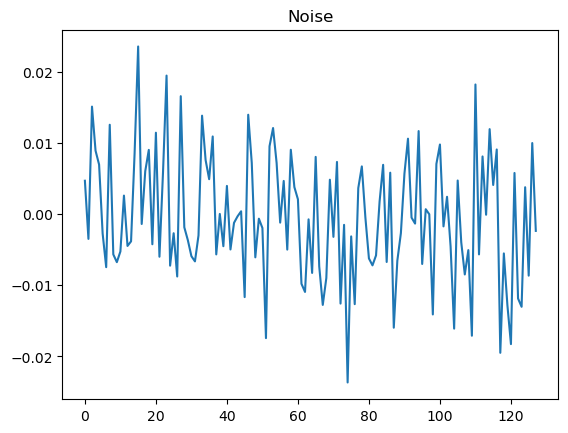

In [17]:
(y_data-probInfo.exactData).plot()
plt.title("Noise");

## 3. Specifying and solving a Bayesian inverse problem  <a class="anchor" id="Bayesian"></a> 

We assume (as a prior) that the elements of $\mathbf{x}$ follow a so-called Gaussian Markov Random Field [(GMRF)](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.GMRF.html#cuqi.distribution.GMRF), which assumes a Gaussian distribution on the differences of the unknown. For the additive noise we assume i.i.d. Gaussian with zero mean and variance $\sigma_e^2$, i.e., precision $d_e = 1/\sigma_e^2$,
$$
\begin{align}
\mathbf{x}&\sim\mathrm{GMRF}(\mathbf{0},50), \\
\mathbf{e}&\sim\mathcal{N}(\mathbf{0},d_e^{-1}\mathbf{I}_n)
\end{align}
$$

From the distribution of $\mathbf{e}$ and the linear model we can write up this with the distribution of $\mathbf{y}$ instead:
$$
\begin{align}
\mathbf{x}&\sim\mathrm{GMRF}(\mathbf{0},50), \\
\mathbf{y}&\sim\mathcal{N}(\mathbf{Ax},d_e^{-1}\mathbf{I}_n).
\end{align}$$

We can specify these distributions in CUQIpy as follows. For $\mathbf{x}$ we have

In [18]:
x = GMRF(np.zeros(A.domain_dim), 50)

And for y we have

In [19]:
d_e_true = 1/0.01**2 
y = Gaussian(A@x, cov=1/d_e_true)

The two distributions are combined in a Bayesian inverse problem:

In [20]:
BP = BayesianProblem(y, x)
print(BP)

BayesianProblem with target: 
 JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI GMRF.
)


This is essentially a joint distribution over `x` and `y` which is also indicated in the print result.

The last step is to provide the observed data for `y`:

In [21]:
BP.set_data(y=y_data)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI GMRF.
 )

Notice how the target of the Bayesian Problem now became a posterior distribution with respect to `x` given `y`.

The "completely non-expert approach" to solving (more detailed approaches described in later notebooks) is to simply run the `UQ` method. 

The `UQ` method looks at the components of the inverse problem, chooses a suitable sampler, samples the posterior and presents results visually:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Linear_RTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 5.247012615203857
Plotting results


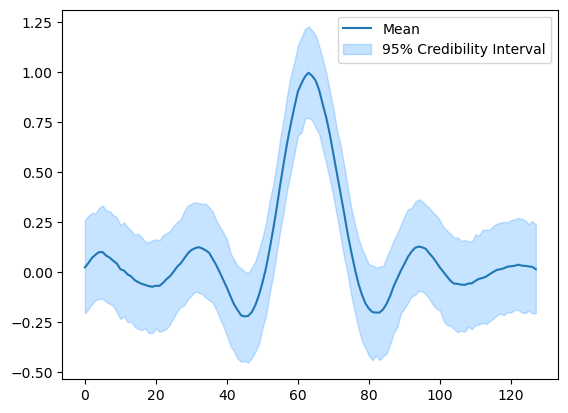

In [22]:
BP.UQ()

To compare with the exact solution (if available) one can pass it as an input, and we can also return the posterior samples (this resamples the problem for illustrative purposes):

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Linear_RTO sampler.
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 5.234013080596924
Plotting results


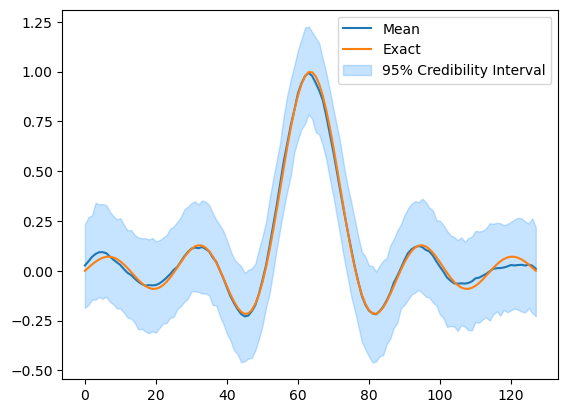

In [23]:
samples = BP.UQ(exact=probInfo.exactSolution)

Having returned the samples allows us to further investigate the posterior in addition to the prefined analysis done by `.UQ()`, for example we can plot 5 randomly chosen samples:

Plotting 5 randomly selected samples


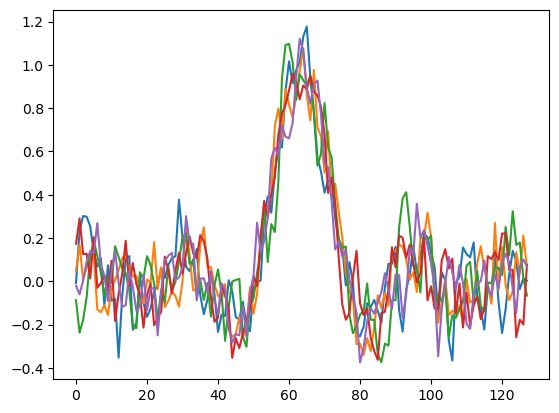

In [24]:
samples.plot();

Or comparing some scatter-type plots of the samples:

Selecting 5 randomly chosen variables


array([[<Axes: ylabel='v37'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v59'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='v72'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='v33', ylabel='v83'>, <Axes: xlabel='v37'>,
        <Axes: xlabel='v59'>, <Axes: xlabel='v72'>]], dtype=object)

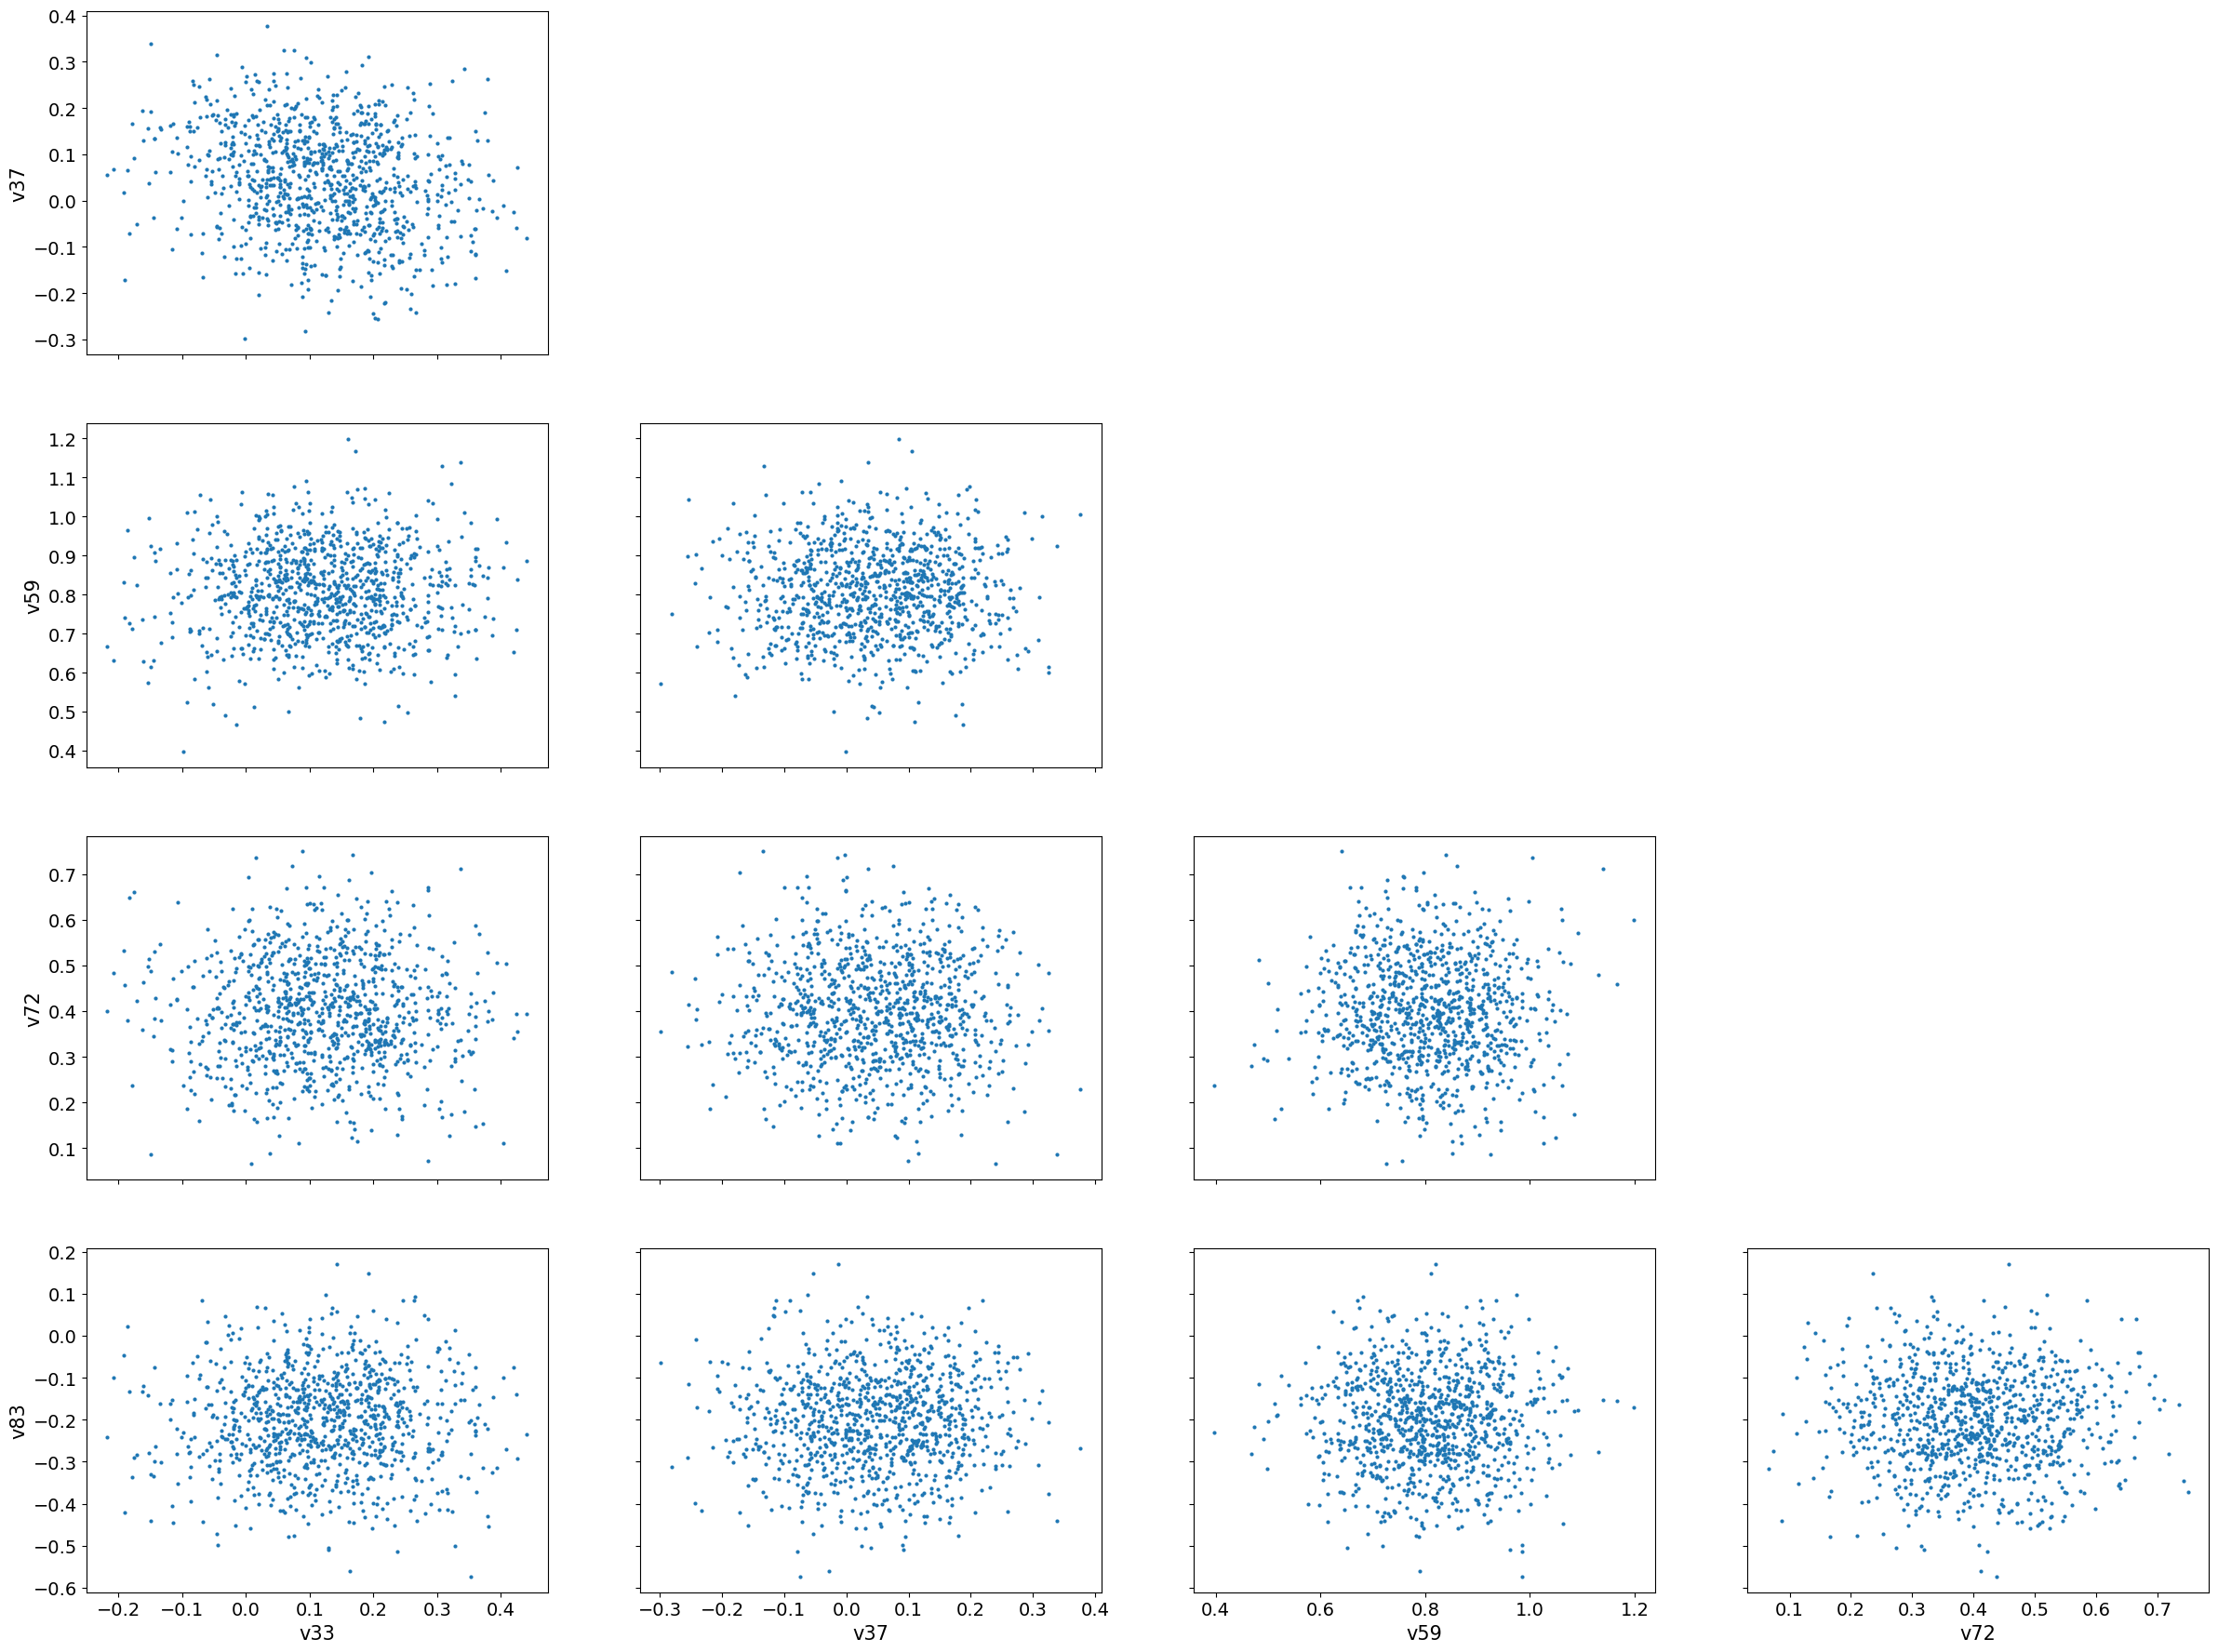

In [25]:
samples.plot_pair()

## Try yourself (optional):  
- Play with the parameters of the Gaussian prior to see if a better solution can be obtained.
- Change phantom to another of the options provided by the TestProblem. Hint: use `help(Deconvolution1D)` to see which phantoms are available.
- Try changing to the `Deconvolution2D` test problem and run the same code.

Go to the top of section 2 to modify the code or add the relevant code in the cell below.

## 4. ★ Changing the prior <a class="anchor" id="ChangingPrior"></a> 

It is straightforward to change components of the BayesianProblem. For example if we want to experiment with a different prior we can easily change the prior for `x`.

Suppose we were working with a different phantom that we know is piecewise constant. We can use a piecewise constant prior instead of the GMRF.

In [26]:
A, y_data, probInfo = Deconvolution1D.get_components(phantom="square", PSF_param=5)

The "square" phantom looks as follows.

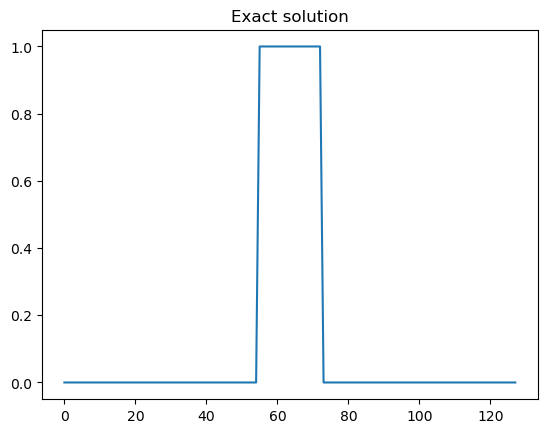

In [27]:
probInfo.exactSolution.plot()
plt.title("Exact solution");

We can specify a [LMRF](https://cuqi-dtu.github.io/CUQIpy/api/_autosummary/cuqi.distribution/cuqi.distribution.LMRF.html) prior, which is a Laplace distribution on differences between neighboring function values:

In [28]:
x = LMRF(location=np.zeros(A.domain_dim), scale=0.01)

The remainder of the steps are exactly the same as before for setting up and solving the Bayesian inverse problem:

Define the Gaussian distribution for y.

In [29]:
d_e_true = 1/0.01**2
y = Gaussian(A@x, cov=1/d_e_true)

We create a new Bayesian Problem (using y from earlier):

In [30]:
BP_lap = BayesianProblem(y, x)
print(BP_lap)

BayesianProblem with target: 
 JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI LMRF.
)


Set the data:

In [31]:
BP_lap.set_data(y=y_data)

BayesianProblem with target: 
 Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI LMRF.
 )

And rerun the `UQ` method:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using UGLA sampler
burn-in: 20%
Sample 1200 / 1200
Elapsed time: 26.80396294593811
Plotting results


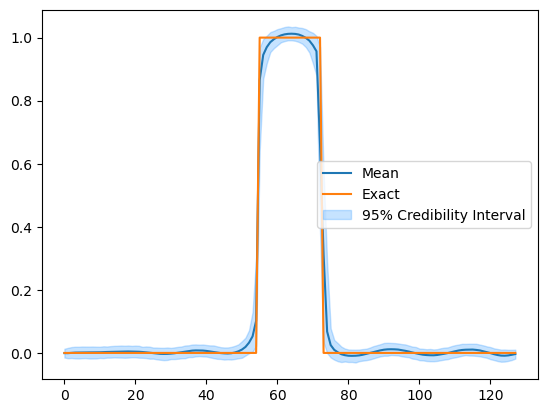

In [32]:
samples_lap = BP_lap.UQ(exact=probInfo.exactSolution)

Note how a different sampler was chosen due to the change of prior, and how the prior has changed the solution to be more similar to the exact solution.

We also plot a few selected samples and note the more piece-wise constant appearance:

Plotting 5 randomly selected samples


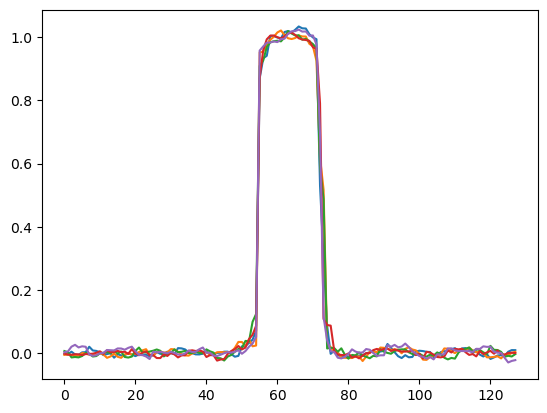

In [33]:
samples_lap.plot();

## Try yourself (optional):  
- Play with the parameters of the Laplace prior to see if a better solution can be obtained.
- Try the `CMRF` prior instead with scale parameter 0.01 (only for `Deconvolution1D`) for an even more edge-preserving prior, which however is more difficult to sample reliably.
- Explore how sampling goes with the `GMRF` prior for the `Square` phantom. What is the issue? Hint: look at the exact solution.

## 5. ★ Gibbs sampling for hierarchical problems <a class="anchor" id="Gibbs"></a>

In the example above we assumed that the mean, std and scale parameters of the prior and noise distributions were known. If these parameters are unknown, we include them as parameters to be estimated in a joint Bayesian inverse problem. Only very few additional lines of CUQIpy are needed to achieve this, through a hierarchical prior.

For example we can assume weakly informative Gamma distribution prior distributions on $d_e$ and $d_x$ such that we have the four random variables:
$$
\begin{align*}
d_x &\sim \mathrm{Gamma}(1, 10^{-4}), \\
d_e  &\sim \mathrm{Gamma}(1, 10^{-4}), \\
\mathbf{x}&\sim\mathbf{LMRF}(\mathbf{0}, d_x^{-1}), \\
\mathbf{y}&\sim\mathcal{N}(\mathbf{Ax}, d_e^{-1}\mathbf{I}_n).
\end{align*}
$$

We specify the four distributions in CUQIpy. To specify the hierarchical structure we use python lambda functions (equivalent to anonymous functions in MATLAB):

In [34]:
d_x = Gamma(1, 1e-4)
d_e = Gamma(1, 1e-4)
x = LMRF(np.zeros(A.domain_dim), lambda d_x : 1/d_x)
y = Gaussian(A@x, cov=lambda d_e : 1/d_e)

and proceed as before to specify the Bayesian Problem, now with the four distributions:

In [35]:
BP = BayesianProblem(y, x, d_e, d_x)
print(BP)

BayesianProblem with target: 
 JointDistribution(
    Equation: 
	p(y,x,d_e,d_x) = p(y|x,d_e)p(x|d_x)p(d_e)p(d_x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x', 'd_e'].
	x ~ CUQI LMRF. Conditioning variables ['d_x'].
	d_e ~ CUQI Gamma.
	d_x ~ CUQI Gamma.
)


Again, we provide the observed data for `y`:

In [36]:
BP.set_data(y=y_data)

BayesianProblem with target: 
 JointDistribution(
    Equation: 
	p(x,d_e,d_x|y) ∝ L(x,d_e|y)p(x|d_x)p(d_e)p(d_x)
    Densities: 
	y ~ CUQI Gaussian Likelihood function. Parameters ['x', 'd_e'].
	x ~ CUQI LMRF. Conditioning variables ['d_x'].
	d_e ~ CUQI Gamma.
	d_x ~ CUQI Gamma.
)

As before, we can run the UQ method, which will use a Gibbs sampler automatically selecting suitable sampling methods for each of the three parameters to be sampled `x`, `d_x` and `d_e`. We provide the true solution for `x` and the true precision for the noise for comparison in the generated plots:

Computing 1000 samples
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!! Automatic sampler selection is experimental. !!!
!!!    Always validate the computed results.     !!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Using Gibbs sampler
burn-in: 20%

Automatically determined sampling strategy:
	x: UGLA
	d_e: Conjugate
	d_x: ConjugateApprox

Warmup 200 / 200
Sample 1000 / 1000
Elapsed time: 43.30208230018616
Plotting results


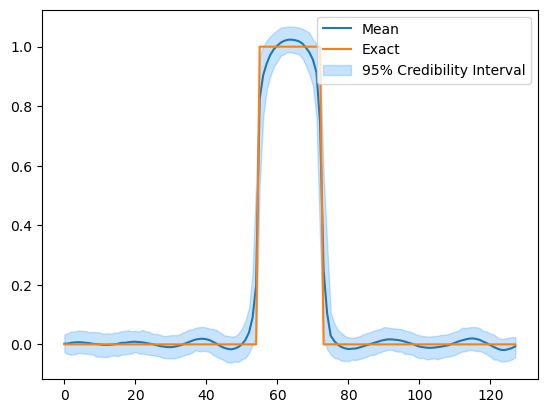

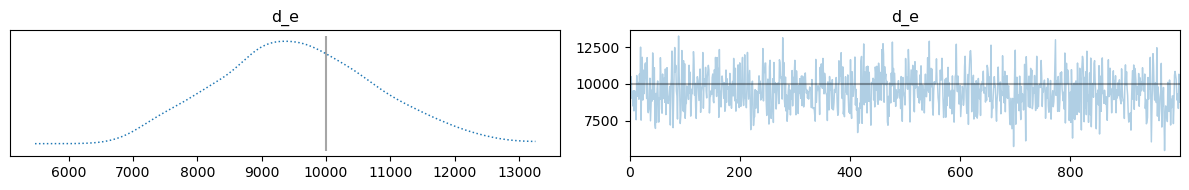

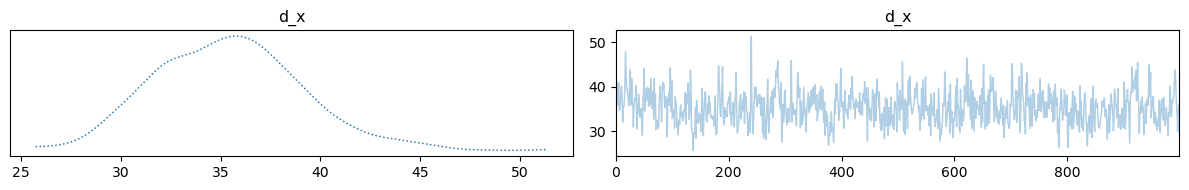

In [37]:
samplesH = BP.UQ(Ns=1000, exact={"x":probInfo.exactSolution, "d_e":d_e_true})

We see the effect of the LMRF prior once again on the solution, and in addition we see trace plots for the `d_x` and `d_e` parameters produced by the `UQ` method with the Gibbs sampler.

Having returned the samples we can pick out the individual parameters and do separate plots manually:

Plotting 5 randomly selected samples


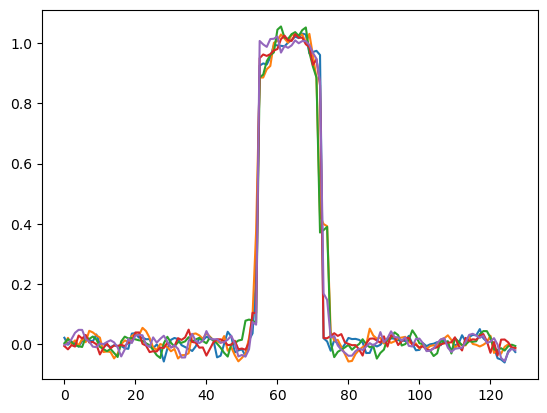

In [38]:
samplesH["x"].plot();

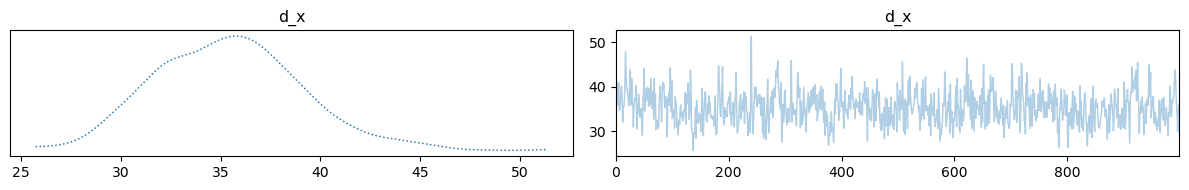

In [39]:
samplesH["d_x"].plot_trace();

## Try yourself (optional):  
- Try the above example with the `Deconvolution2D` test problem instead of `Deconvolution1D` and with phantom "cookie". You should be able to replicate the results from the introductory example in the [CUQIpy paper](https://arxiv.org/abs/2305.16949). 
- Note for the 2D problem you need to specify `geometry=A.domain_geometry` as a keyword argument to `LMRF` to ensure the difference operator is applied on a 2D image grid.